In [ ]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import torch
from torch import nn, optim
from torch.nn import KLDivLoss
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Categorical, Normal

import pyro
from pyro.infer import MCMC, HMC as pyro_hmc, NUTS as pyro_nuts

from tqdm.notebook import tqdm, trange
import numpy as np

import matplotlib.pyplot as plt

# Distributions

In [ ]:
from scipy.stats import gaussian_kde


class Funnel(object):
    """
    Funnel distribution.

    “Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

    Args:
        dim - dimension
    """
    def __init__(self, num_dims=2):
        self.num_dims = num_dims
        self.normal_first = Normal(0, 1)

    @property
    def dim(self) -> int:
        return self.num_dims

    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        normal_last = Normal(torch.zeros(x.shape[:-1], device=x.device), torch.exp(x[..., 0] / 2.))
        return normal_last.log_prob(x[..., 1:].permute(-1, *range(x.ndim-1))).sum(0) + self.normal_first.log_prob(x[..., 0])

    def likelihood(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            p(x)
        """
        return torch.exp(self.log_prob(x))

    def plot_2d_countour(self, ax):
        """
        Visualizes contour plot of Funnel distribution using log p(x)
        """
        x = np.linspace(-15, 15, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])

        ax.contour(Y, X, Z.exp(),
                   levels=3,
                   alpha=1., colors='midnightblue', linewidths=1)

    def visualize_dist(self, s=10000):
        """
        Visualizes Funnel distribution using sampled points
        """
        # Generate points from funnel distribution
        points = np.transpose(self.sample(s))
        Y = points[0]
        X = points[1]

        # Calculate the point density
        XY = np.vstack([X,Y])
        Z = gaussian_kde(XY)(XY)

        # Sort the points by density, so that the densest points are plotted last
        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        plt.scatter(X, Y, c=Z, label=Z)
        plt.colorbar()
        plt.show()
        plt.close()

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Sample from the Funnel distribution
        """
        all_c = torch.randn((num_samples, self.dim))
        all_c[:, 0] = all_c[:, 0] * 1**0.5
        all_c[:, 1:] = all_c[:, 1:]*(torch.exp(1*all_c[:, 0]))[:, None]
        return all_c

    def estimate_dist(self, s=100000):
        """
        Estimates mean and standard deviation of the Funnel distribution
        by sampling from it
        """
        target_samp = self.sample(s)
        std = torch.std(target_samp, dim=0).numpy()
        m = torch.mean(target_samp, dim=0).numpy()
        return [m, std]

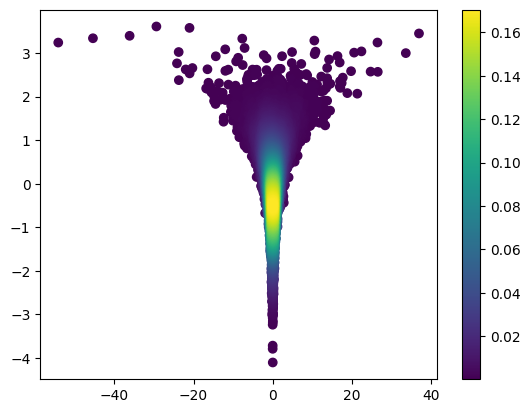

In [ ]:
funnel = Funnel(num_dims=2)
funnel.visualize_dist(s=10000)

In [ ]:
class Banana:

    def __init__(self, b=0.02, dim=2):
        self.b = b
        self.dim = dim
        self.sigma = 10 # can be changed

    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        even = np.arange(0, x.shape[-1], 2)
        odd = np.arange(1, x.shape[-1], 2)
        ll = -0.5 * (x[..., odd] - self.b * x[..., even]**2 + (self.sigma**2) * self.b)**2 - ((x[..., even])**2)/(2 * self.sigma**2)
        return ll.sum(-1)

    def likelihood(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            p(x)
        """
        return torch.exp(self.log_prob(x))

    def sample(self, s):
        """
        Sample from the Banana distribution
        """
        torch.manual_seed(926)
        even = np.arange(0, self.dim, 2)
        odd = np.arange(1, self.dim, 2)
        var = torch.ones(self.dim)
        var[..., even] = self.sigma**2
        base_dist = MNormal(torch.zeros(self.dim), torch.diag(var))
        samples = base_dist.sample((s,))
        samples[..., odd] += self.b * samples[..., even]**2 - self.b * self.sigma**2
        return samples

    def plot_2d_countour(self, ax):
        """
        Visualizes contour plot of Banana distribution using log p(x)
        """
        x = np.linspace(-20, 20, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])
        ax.contour(X, Y, Z.exp(),
                   levels=5,
                   alpha=1., colors='midnightblue', linewidths=1)

    def visualize_dist(self, s=1000):
        """
        Visualizes Banana distribution using sampled points
        """
        # Generate points from distribution
        points = self.sample(s)
        X = points[:, 0]
        Y = points[:, 1]

        # Calculate the point density
        XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
        Z = gaussian_kde(XY)(XY)

        # Sort the points by density, so that the densest points are plotted last
        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        plt.scatter(X, Y, c=Z, label=Z)
        plt.colorbar()
        plt.show()
        plt.close()

    def estimate_dist(self, s=10000000):
        """
        Estimates mean and standard deviation of the Banana distribution
        by sampling from it
        """
        target_samp = self.sample(s)
        std = torch.std(target_samp, dim=0).numpy()
        m = torch.mean(target_samp, dim=0).numpy()
        return [m, std]

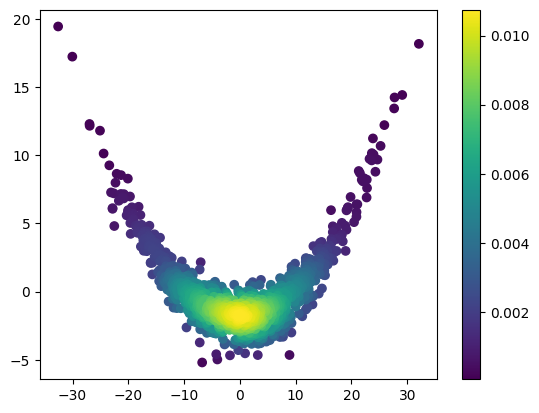

In [ ]:
banana = Banana(b=0.02, dim=2)
banana.visualize_dist()

In [ ]:
# Target
class GaussianMixture:
    def __init__(self, dim, sigma, loc):
        self.g0 = MNormal(loc, sigma ** 2 * torch.eye(dim))
        self.g1 = MNormal(-loc, sigma ** 2 * torch.eye(dim))
        self.prob = 0.5
        self.dim = dim

    def sample(self, shape=(2,)):
        idx = torch.rand(shape) < self.prob
        samples = torch.zeros((*shape, self.dim))
        samples[idx, :] = self.g0.sample(shape)[idx, :]
        samples[~idx, :] = self.g1.sample(shape)[~idx, :]
        return samples

    def probability(self, x):
        return 0.5 * self.g0.log_prob(x).exp() + 0.5 * self.g1.log_prob(x).exp()

    def log_prob(self, x):
        return (0.5 * self.g0.log_prob(x).exp() + 0.5 * self.g1.log_prob(x).exp() + 1e-8).log()


# Proposal
class Cauchy:
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale
        self.dim = len(self.loc)
        self.distr = torch.distributions.Cauchy(self.loc, self.scale)

    def probability(self, x):
        return self.distr.log_prob(z).mean(-1).log()

    def log_prob(self, z):
        log_target = self.distr.log_prob(z).sum(-1)#.mean(-1)
        return log_target

    def sample(self, n=(1,)):
        return self.distr.sample(n)



# Samplers

In [ ]:
def ISIR(start: torch.FloatTensor,
        target,
        proposal,
        n_samples: int,
        burn_in: int,
        *,
        n_particles: int,
        verbose: bool=False):
    """
    Iterated Sampling Importance Resampling

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        n_particles - number of particles including one from previous step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []

    x = start.clone()
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)
    n_chains, dim = x.size()
    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        logqs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        logps = torch.cat([logp_x[:, None], target.log_prob(particles.reshape(-1, dim)).reshape(n_chains, -1)], 1)
        #logps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = logps - logqs
        indices = Categorical(logits=log_weights).sample()

        x = particles[np.arange(x.shape[0]), indices]
        logp_x = logps[np.arange(x.shape[0]), indices]
        logq_x = logqs[np.arange(x.shape[0]), indices]

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

In [ ]:
from pyro.infer import HMC as pyro_hmc
from pyro.infer import MCMC
from pyro.infer import NUTS as pyro_nuts


def NUTS(start,
        target,
        n_samples: int,
        burn_in: int,
        *,
        verbose: bool = False) -> torch.FloatTensor:
    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_nuts(potential_fn=energy, full_mass=False)
    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true, _

In [178]:
def HMC(
    start,
    target,
    n_samples: int,
    burn_in: int,
    *,
    step_size: float,
    num_leapfrog_steps: float = 1,
    verbose: bool = False,
) -> torch.FloatTensor:
    """
    Hamiltonian Monte Carlo

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates
        for each iteration
    """

    x = start.clone().detach()
    #print("X is leaf? ", x.is_leaf)
    x.requires_grad_(False)

    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_hmc(
        potential_fn=energy,
        step_size=step_size,
        num_steps=num_leapfrog_steps,
        full_mass=False,
    )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true

# MSC
Example with Normal distributions

In [ ]:
from torch.optim.lr_scheduler import StepLR


# KL we try to minimize
def KL_div(log_p, log_q, eps=1e-7):
    l = torch.exp(log_p) * (log_p - log_q)
    return l.sum()


# define distributions
dim = 2
# define target
target =  MNormal(2 * torch.ones(dim), 3 * torch.eye(dim)) # Banana(b=0.02, dim=dim)
# define learnable parameters of proposal
# Pass to proposal like: proposal = MNormal(**learnable_params)
learnable_params = nn.ParameterDict({
    'loc': nn.Parameter(torch.zeros(dim), requires_grad=True),
    'covariance_matrix' : nn.Parameter(torch.eye(dim), requires_grad=True)
})


# define params for chain
N_CHAINS = 2
N_SAMPLES = 100
BURN_IN = 100

# optimizer
optimizer = optim.AdamW(lr=1e-1, params=learnable_params.parameters())
# decay lr: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
scheduler = StepLR(optimizer, 1, gamma=1 - 1e-4)

# MSC iteration
n_iter = 100

loss_arr = []
kl_arr = []


for i in tqdm(range(n_iter)):

    optimizer.zero_grad()

    # define proposal with new params
    proposal = MNormal(**learnable_params)


    # sample from it
    with torch.no_grad():
        chains, _ = ISIR(
        proposal.sample((N_CHAINS, )),
        target,
        proposal,
        N_SAMPLES,
        BURN_IN,
        n_particles=100)

        # функция тупая и не пашет с одной цепью
        chain = chains[:, 0]

        # chains, _ = NUTS(
        # proposal.sample((N_CHAINS,)),
        # target,
        # N_SAMPLES,
        # BURN_IN,
        # )

    # get
    log_p = target.log_prob(chain)
    log_q = proposal.log_prob(chain)

    loss = (-1 * torch.exp(log_p) * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    with torch.no_grad():
        loss_arr.append(loss.detach().item())
        kl_arr.append(KL_div(log_p, log_q))

  0%|          | 0/100 [00:00<?, ?it/s]

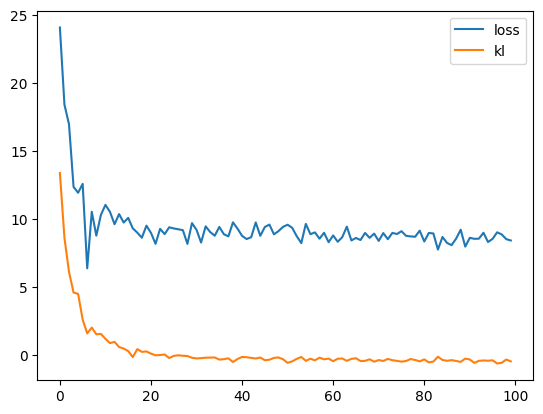

In [ ]:
plt.plot(loss_arr, label='loss')
plt.plot(kl_arr, label='kl')
plt.legend()
plt.show()

Now let's draw what we sampled

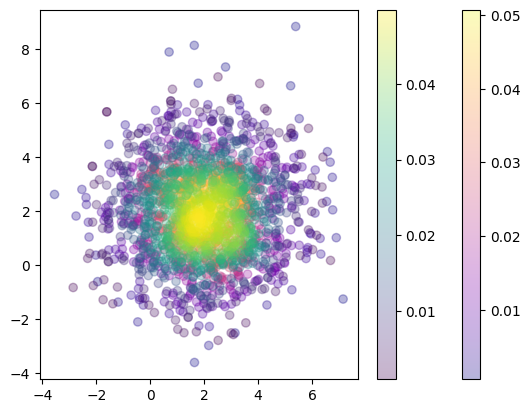

In [ ]:
# Now target
points = target.sample((1000,))

# Generate points from distribution
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='plasma', alpha=0.3)
plt.colorbar()

chains, _ = ISIR(
        proposal.sample((2, )),
        target,
        proposal,
        1000,
        BURN_IN,
        n_particles=100)

# Generate points from distribution
points = chains[:, 0]
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='viridis', alpha=0.3)
plt.colorbar()

plt.show()
plt.close()

## Banana

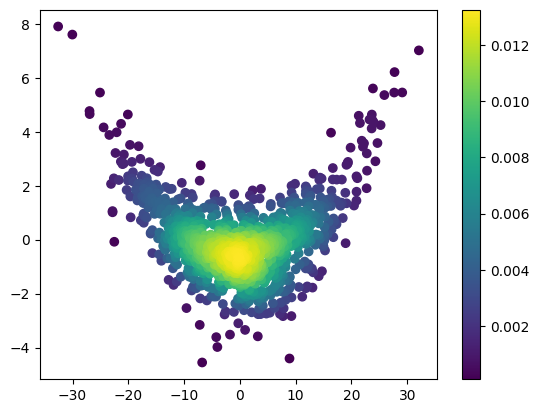

In [ ]:
target =  Banana(b=8e-3, dim=dim)
target.visualize_dist()

  0%|          | 0/2000 [00:00<?, ?it/s]

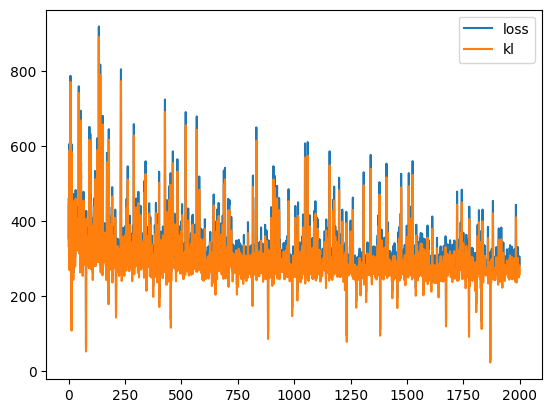

In [ ]:
# define distributions
dim = 2
# define target
target = Banana(b=8e-3, dim=dim)
# define learnable parameters of proposal
# Pass to proposal like: proposal = MNormal(**learnable_params)
learnable_params = nn.ParameterDict({
    'loc': nn.Parameter(torch.zeros(dim), requires_grad=True),
    'covariance_matrix' : nn.Parameter(torch.eye(dim) + 1e-3, requires_grad=True)
})


# define params for chain
N_CHAINS = 2
N_SAMPLES = 100
BURN_IN = 100

# optimizer
optimizer = optim.AdamW(lr=3e-2, params=learnable_params.parameters())
# decay lr: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
scheduler = StepLR(optimizer, 1, gamma=1 - 1e-3)

# MSC iteration
n_iter = 2000

loss_arr = []
kl_arr = []


for i in tqdm(range(n_iter)):

    optimizer.zero_grad()

    # define proposal with new params
    proposal = MNormal(**learnable_params)


    # sample from it
    with torch.no_grad():
        chains, _ = ISIR(
        proposal.sample((N_CHAINS, )),
        target,
        proposal,
        N_SAMPLES,
        BURN_IN,
        n_particles=100)

        # функция тупая и не пашет с одной цепью
        chain = chains[:, 0]

        # chains, _ = NUTS(
        # proposal.sample((N_CHAINS,)),
        # target,
        # N_SAMPLES,
        # BURN_IN,
        # )

    # get
    log_p = target.log_prob(chain)
    log_q = proposal.log_prob(chain)

    loss = (-1 * torch.exp(log_p) * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    with torch.no_grad():
        loss_arr.append(loss.detach().item())
        kl_arr.append(KL_div(log_p, log_q))


plt.plot(loss_arr, label='loss')
plt.plot(kl_arr, label='kl')
plt.legend()
plt.show()

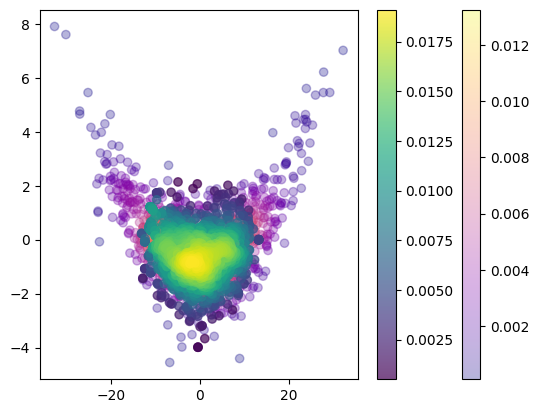

In [ ]:
# Now target
points = target.sample(1000)

# Generate points from distribution
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='plasma', alpha=0.3)
plt.colorbar()

chains, _ = ISIR(
        proposal.sample((2, )),
        target,
        proposal,
        1000,
        BURN_IN,
        n_particles=100)

# Generate points from distribution
points = chains[:, 0]
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='viridis', alpha=0.7)
plt.colorbar()

plt.show()
plt.close()

## Funnel

  0%|          | 0/1000 [00:00<?, ?it/s]

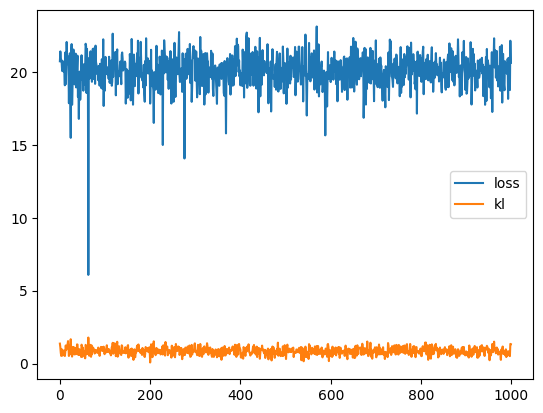

In [ ]:
# define distributions
dim = 2
# define target
target = Funnel(num_dims=2)
# define learnable parameters of proposal
# Pass to proposal like: proposal = MNormal(**learnable_params)
learnable_params = nn.ParameterDict({
    'loc': nn.Parameter(torch.zeros(dim), requires_grad=True),
    'covariance_matrix' : nn.Parameter(torch.eye(dim) + 1e-3, requires_grad=True)
})


# define params for chain
N_CHAINS = 2
N_SAMPLES = 100
BURN_IN = 100

# optimizer
optimizer = optim.AdamW(lr=3e-2, params=learnable_params.parameters())
# decay lr: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
scheduler = StepLR(optimizer, 1, gamma=0.1)

# MSC iteration
n_iter = 1000

loss_arr = []
kl_arr = []


for i in tqdm(range(n_iter)):

    optimizer.zero_grad()

    # define proposal with new params
    proposal = MNormal(**learnable_params)


    # sample from it
    with torch.no_grad():
        chains, _ = ISIR(
        proposal.sample((N_CHAINS, )),
        target,
        proposal,
        N_SAMPLES,
        BURN_IN,
        n_particles=100)

        # функция тупая и не пашет с одной цепью
        chain = chains[:, 0]

        # chains, _ = NUTS(
        # proposal.sample((N_CHAINS,)),
        # target,
        # N_SAMPLES,
        # BURN_IN,
        # )

    # get
    log_p = target.log_prob(chain)
    log_q = proposal.log_prob(chain)

    loss = (-1 * torch.exp(log_p) * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    with torch.no_grad():
        loss_arr.append(loss.detach().item())
        kl_arr.append(KL_div(log_p, log_q))


plt.plot(loss_arr, label='loss')
plt.plot(kl_arr, label='kl')
plt.legend()
plt.show()

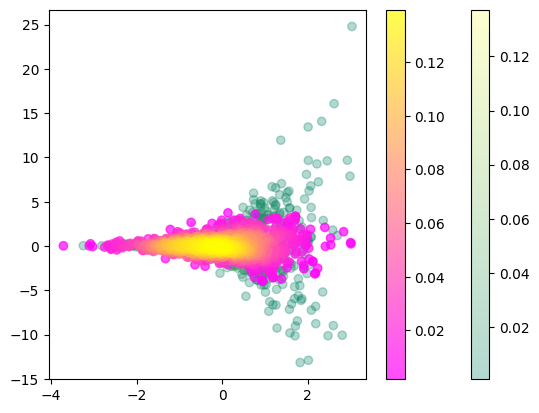

In [ ]:
# Now target
points = target.sample(1000)

# Generate points from distribution
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='summer', alpha=0.3)
plt.colorbar()

chains, _ = ISIR(
        proposal.sample((2, )),
        target,
        proposal,
        1000,
        BURN_IN,
        n_particles=100)

# Generate points from distribution
points = chains[:, 0]
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='spring', alpha=0.7)
plt.colorbar()

plt.show()
plt.close()

# TSC
## Affine

In [ ]:
def affine_transform(eps, loc, scale):
    return loc + scale * eps

def inverse_affine_transform(eps, loc, scale):
    return (eps - loc) / scale

### Banana

  0%|          | 0/1000 [00:00<?, ?it/s]

Sample: 100%|██████████| 200/200 [00:00, 330.52it/s, step size=8.48e-01, acc. prob=0.921]


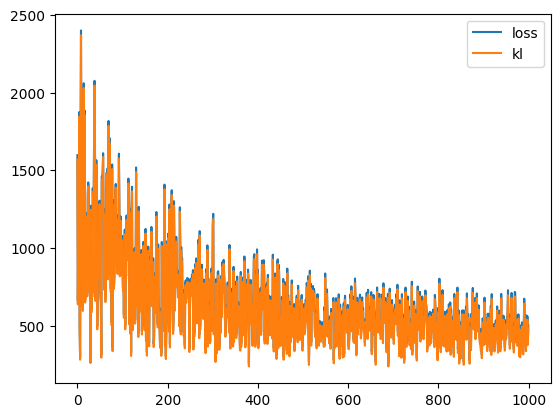

In [184]:
# define distributions
dim = 2
# define target
target = Banana(b=8e-3, dim=dim)
# define learnable parameters of proposal
# Pass to proposal like: proposal = MNormal(**learnable_params)
learnable_params = nn.ParameterDict({
    'loc': nn.Parameter(torch.zeros(dim), requires_grad=True),
    'scale' : nn.Parameter(torch.ones(1), requires_grad=True)
})


# define params for chain
N_CHAINS = 2
N_SAMPLES = 100
BURN_IN = 100

# optimizer
optimizer = optim.AdamW(lr=3e-3, params=learnable_params.parameters())
# decay lr: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
scheduler = StepLR(optimizer, 1, gamma=1 - 1e-3)

# MSC iteration
n_iter = 1000

loss_arr = []
kl_arr = []


# first init
proposal = MNormal(learnable_params['loc'], torch.eye(dim) * (learnable_params['scale'] ** 2))
z_0 = proposal.sample((N_CHAINS, ))

for i in tqdm(range(n_iter)):

    optimizer.zero_grad()

    # define proposal with new params
    proposal = MNormal(learnable_params['loc'], torch.eye(dim) * (learnable_params['scale'] ** 2))

    # sample from it
    # with torch.no_grad():
        # chains, _ = ISIR(
        # z_0,
        # target,
        # proposal,
        # N_SAMPLES,
        # BURN_IN,
        # n_particles=100)

    chains = HMC(
        proposal.sample((N_CHAINS,)),
        target,
        N_SAMPLES,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

    # функция тупая и не пашет с одной цепью
    chain = chains[:, 0].detach()

    z = affine_transform(chain, learnable_params['loc'], learnable_params['scale'])
    # get
    log_p = target.log_prob(chain)
    log_q = proposal.log_prob(chain)

    loss = (-1 * torch.exp(log_p) * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    with torch.no_grad():
        loss_arr.append(loss.detach().item())
        kl_arr.append(KL_div(log_p, log_q))
        z_0 = inverse_affine_transform(z[:1], learnable_params['loc'], learnable_params['scale'])


plt.plot(loss_arr, label='loss')
plt.plot(kl_arr, label='kl')
plt.legend()
plt.show()

Sample: 100%|██████████| 1100/1100 [00:01, 594.90it/s, step size=6.52e-01, acc. prob=0.946]


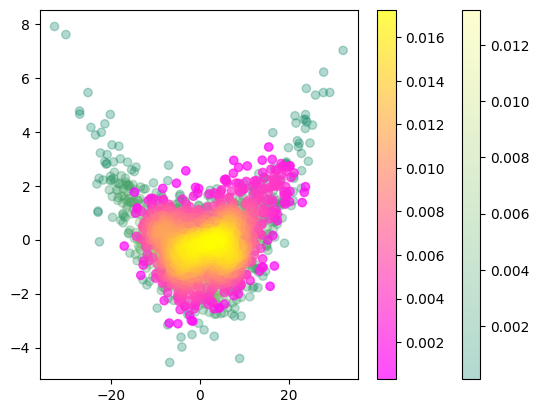

In [186]:
# Now target
points = target.sample(1000)

# Generate points from distribution
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='summer', alpha=0.3)
plt.colorbar()

chains = HMC(
        proposal.sample((N_CHAINS,)),
        target,
        1000,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

# Generate points from distribution
points = chains[:, 0]
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='spring', alpha=0.7)
plt.colorbar()

plt.show()
plt.close()

### Funnel

  0%|          | 0/1000 [00:00<?, ?it/s]

Sample: 100%|██████████| 200/200 [00:01, 190.96it/s, step size=3.58e-01, acc. prob=0.844]


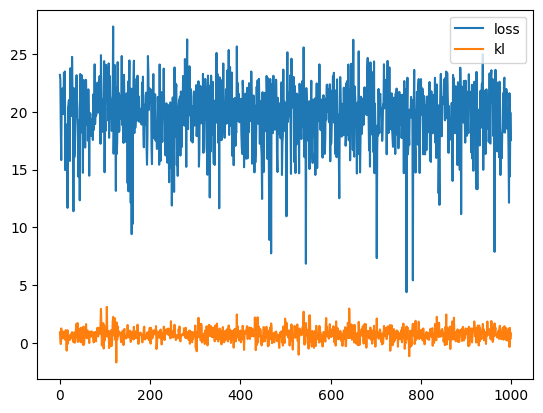

In [187]:
# define distributions
dim = 2
# define target
target = Funnel(num_dims=2)
# define learnable parameters of proposal
# Pass to proposal like: proposal = MNormal(**learnable_params)
learnable_params = nn.ParameterDict({
    'loc': nn.Parameter(torch.zeros(dim), requires_grad=True),
    'scale' : nn.Parameter(torch.ones(1), requires_grad=True)
})


# define params for chain
N_CHAINS = 2
N_SAMPLES = 100
BURN_IN = 100

# optimizer
optimizer = optim.AdamW(lr=3e-2, params=learnable_params.parameters())
# decay lr: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
scheduler = StepLR(optimizer, 1, gamma=0.1)

# MSC iteration
n_iter = 1000

loss_arr = []
kl_arr = []


# first init
proposal = MNormal(learnable_params['loc'], torch.eye(dim) * (learnable_params['scale'] ** 2))
z_0 = proposal.sample((N_CHAINS, ))

for i in tqdm(range(n_iter)):

    optimizer.zero_grad()

    # define proposal with new params
    proposal = MNormal(learnable_params['loc'], torch.eye(dim) * (learnable_params['scale'] ** 2))

    chains = HMC(
        proposal.sample((N_CHAINS,)),
        target,
        N_SAMPLES,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

    # функция тупая и не пашет с одной цепью
    chain = chains[:, 0].detach()


    z = affine_transform(chain, learnable_params['loc'], learnable_params['scale'])
    # get
    log_p = target.log_prob(chain)
    log_q = proposal.log_prob(chain)

    loss = (-1 * torch.exp(log_p) * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    with torch.no_grad():
        loss_arr.append(loss.detach().item())
        kl_arr.append(KL_div(log_p, log_q))
        z_0 = inverse_affine_transform(z[:1], learnable_params['loc'], learnable_params['scale'])


plt.plot(loss_arr, label='loss')
plt.plot(kl_arr, label='kl')
plt.legend()
plt.show()

Sample: 100%|██████████| 1100/1100 [00:02, 490.99it/s, step size=6.61e-01, acc. prob=0.855]


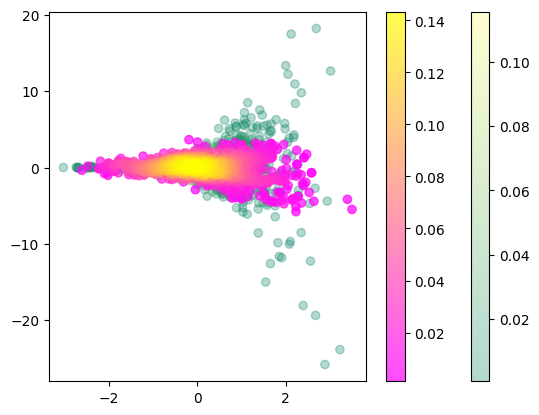

In [188]:
# Now target
points = target.sample(1000)

# Generate points from distribution
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='summer', alpha=0.3)
plt.colorbar()

chains = HMC(
        proposal.sample((N_CHAINS,)),
        target,
        1000,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

# Generate points from distribution
points = chains[:, 0]
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='spring', alpha=0.7)
plt.colorbar()

plt.show()
plt.close()